In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [33]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.inference_early_stop import InferenceEarlyStop
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import (
    clear_iteration_dirs,
    get_iteration,
    get_last_iteration_dir,
    last_tune_log,
    tune,
    Verbosity,
)
from lib.utils import rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "036"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks(surprise_bonus=3e-1))
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

(64, 64, 2860)

In [34]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 300  # Expected completion tokens per task sample
inference_early_stop = InferenceEarlyStop(alpha=0.992, threshold=-3.0)
wandb.config["lr"] = lr = 2e-6
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0005 --port=8001 --api-key=default
INFO 02-22 20:08:38 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 20:08:40 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 20:08:40 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0005', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.09s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:06,  3.21s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.10s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.00s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.90s/it]



INFO 02-22 20:09:06 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 20:09:07 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-22 20:09:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 20:09:07 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 20:09:07 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 20:09:07 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 20:10:06 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 59.14 seconds
INFO 02-22 20:10:07 api_server.py:756] Using supplied chat template:
INFO 02-22 20:10:07 api_server.py:756] None
INFO 02-22 20:10:07 launcher.py:21] Available routes are:
INFO 02-22 20:10:07 launcher.py:29] Route: /

INFO:     Started server process [43195]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-22 20:10:13 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-22 20:10:13 metrics.py:455] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-22 20:10:13 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:37546 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/128 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

Early stopping - ewm_logprob: -3.025791287315106 completion_tokens: 137
Early stop last 100 characters: ible hints guiding user candidates have diverse expectations and prerequisites, which separates them
Early stopping - ewm_logprob: -3.0182868797372397 completion_tokens: 225
Early stop last 100 characters: hmark does remain subject to inherent assumption of the Analyst. Manual verification can demonstrate
Early stopping - ewm_logprob: -3.000503883806268 completion_tokens: 193
Early stop last 100 characters: r AI rather than a limited-human. Also, finding identification while calculating would stimuli human
Early stopping - ewm_logprob: -3.0007429942717394 completion_tokens: 193
Early stop last 100 characters: lve. Distinguished monochrome manner habituates laborious dedication. For sure, the one you composed
Early stopping - ewm_logprob: -3.009697501554421 completion_tokens: 209
Early stop last 100 characters: ference suggested as the most plausible resolution method. We are lucky th

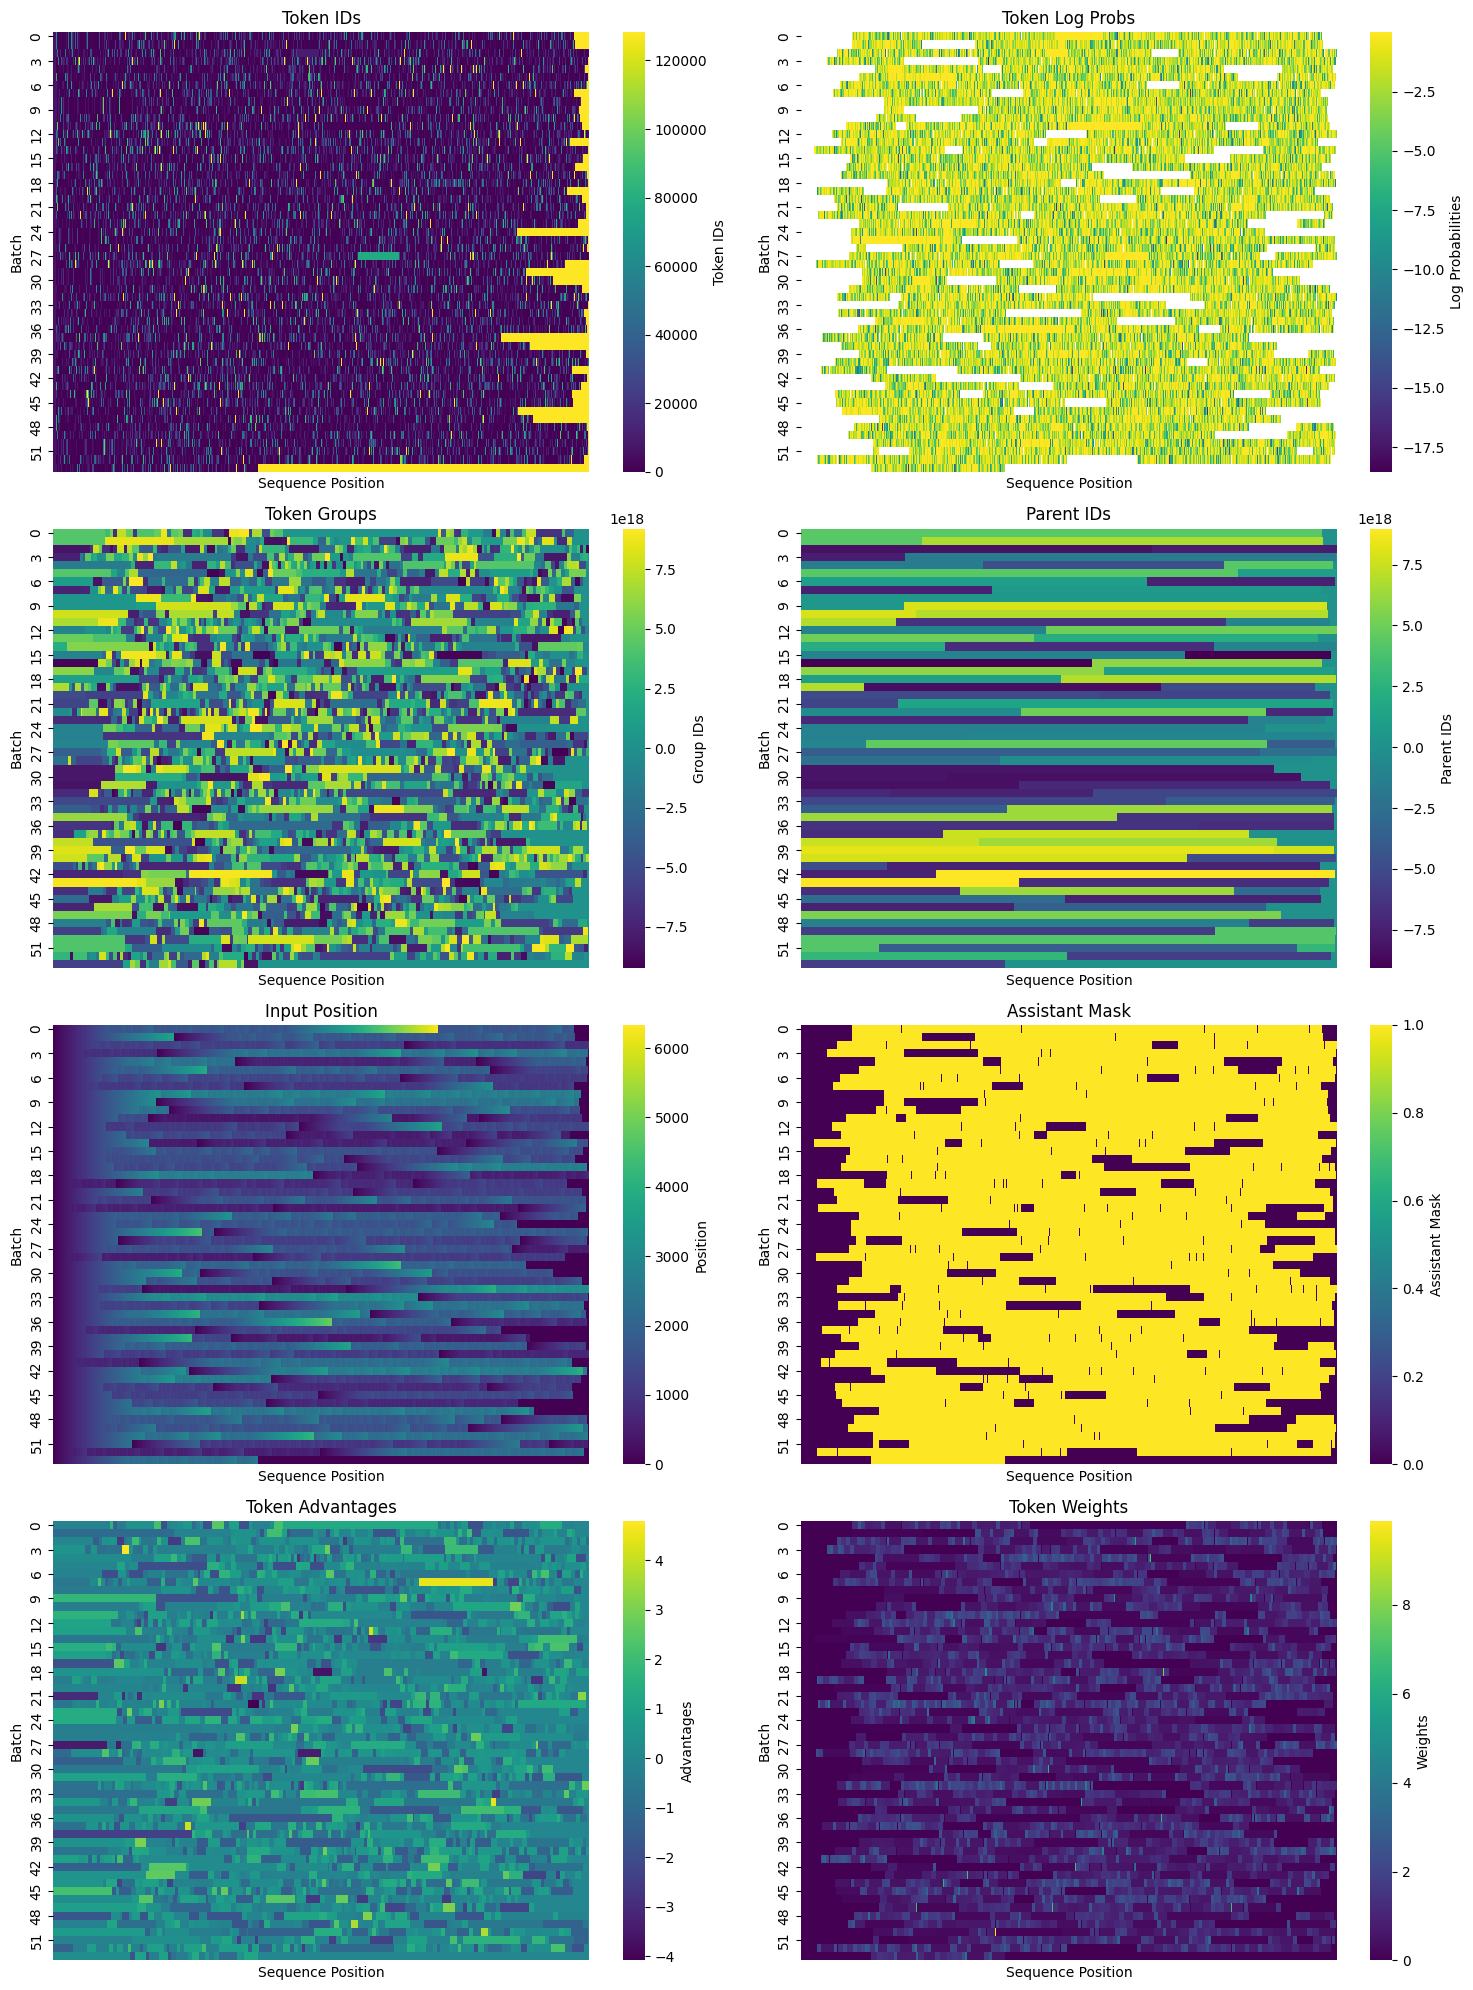

rsyncing /home/ubuntu/sky_workdir/experiments/models/036 to gs://atreides/openpipe/models/036


CancelledError: 

In [35]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            n=2,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            on_chunk=inference_early_stop,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_completion_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    for metric in val_stats.total_metrics:
        wandb_data[metric] = val_stats.total_metrics[metric] / val_stats.grades
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=model.tune_max_batch_tokens // seq_len,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
            compile=True,
        ),
        verbosity=verbosity,
    )

In [39]:
train_results[0]

[TokenizedResult(conversation=[{'role': 'user', 'content': 'On a dark winter night, wealthy and enigmatic Mr. John Q. Boddy hosted a small, but lavish, dinner party for some of his closest associates. However, the night ended in tragedy when Mr. Boddy was found dead in one of the rooms of Tudor Mansion in the early hours of the morning. The following persons of interest have been identified as suspects:\n\n• Sgt. Gray\n• Mrs. Peacock\n• Colonel Mustard\n• Monsieur Brunette\n• Mrs. White\n• Madame Rose\n• Miss Scarlet\n• Miss Peach\n• Mr. Green\n\nAnd the following weapons were found on the premises:\n\n• Revolver\n• Lead Pipe\n• Poison\n• Rope\n• Wrench\n\nThe murder could only have occured in one of the following rooms:\n\n01. Dining Room\n02. Billiard Room\n03. Ballroom\n04. Library\n05. Lounge\n06. Kitchen\n07. Conservatory\n08. Cloak Room\n09. Gazebo\n10. Studio\n11. Courtyard\n12. Drawing Room\n\nThe rooms are laid out as follows:\n\n  NN NN NN NN  \nW 01|02|03|04 E\nW 05|06|07|08

In [40]:
[e for rs in train_results for r in rs for e in r.exceptions]

AttributeError: 'TokenizedResult' object has no attribute 'exceptions'

In [5]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
vllm = await start_vllm(
    model_name,
    max_concurrent_requests=1024,
    env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=1024,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=180 + 15 * torch.cuda.device_count(),
    verbosity=verbosity,
)

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/036/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/036/0005 --port=8000 --api-key=default
INFO 02-22 19:41:59 __init__.py:190] Automatically detected platform cuda.
INFO 02-22 19:42:00 api_server.py:840] vLLM API server version 0.7.2
INFO 02-22 19:42:00 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/036/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.57s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:10<00:03,  3.57s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.21s/it]



INFO 02-22 19:42:30 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-22 19:42:31 worker.py:267] Memory profiling takes 0.92 seconds
INFO 02-22 19:42:31 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-22 19:42:31 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-22 19:42:31 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-22 19:42:31 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-22 19:43:25 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 55.06 seconds
INFO 02-22 19:43:26 api_server.py:756] Using supplied chat template:
INFO 02-22 19:43:26 api_server.py:756] None
INFO 02-22 19:43:26 launcher.py:21] Available routes are:
INFO 02-22 19:43:26 launcher.py:29] Route: /

INFO:     Started server process [32962]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-22 19:43:28 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42290 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


In [32]:
from openai.types.chat.chat_completion import ChatCompletion, Choice
from openai.types.chat.chat_completion_chunk import ChatCompletionChunk

ewm_logprobs: dict[str, float] = {}
alpha = 0.992


def on_chunk(chunk: ChatCompletionChunk, completion: ChatCompletion) -> None:
    if not chunk.choices or not chunk.choices[0].logprobs:
        return
    assert chunk.choices[0].logprobs.content is not None
    for token_logprob in chunk.choices[0].logprobs.content:
        ewm_logprob = (
            alpha * ewm_logprobs.get(completion.id, 0)
            + (1 - alpha) * token_logprob.logprob
        )
        if ewm_logprob < -3:
            print(
                f"Early stopping - ewm_logprob: {ewm_logprob} completion_tokens: {len(completion.choices[0].logprobs.content)}"  # type: ignore
            )
            print(completion.choices[0].message.content)
            raise StopIteration()
        ewm_logprobs[completion.id] = ewm_logprob


semaphore = asyncio.Semaphore(int(1.33 * vllm.max_concurrent_tokens / expected_tokens))
offset = 0
val_results, train_results = await asyncio.gather(
    get_task_results(
        tasks=val_tasks[:32],
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        n=2,
        on_chunk=on_chunk,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="val",
        semaphore=semaphore,
    ),
    get_task_results(
        tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter))[:1],
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=False,
        on_chunk=on_chunk,
        n=samples_per_task,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
            max_completion_tokens=8192,
        ),
        pbar_desc="train",
        semaphore=semaphore,
        transform=TaskResultTokenizer(tokenizer),
    ),
)

val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/50 [00:00<?, ?it/s]

Early stopping - ewm_logprob: -3.242501011950084 completion_tokens: 169
A. Mr. Green 
B. Lounge
C. 11:45 PM
D. Lounge 

Without going into too much detail, the Lodge analysis technique combined with trial and error is useful to solve this. By using the weakest links to eliminate possibilities, the correct answer is achievable. Finally, when all options are exhausted, the answer is complete. It is also crucial to remain focused on the most probable suspect movements due to the conditions imposed.粗 羽毛拂去 纸胸针 CUDA 法 揭示كاست 建立了智慧的健身房,勤奋的秦足的人们移民到洗送的有框架的馆小楼。另据信arefa 刊发了 hấp波切牙烘传播的设 Muslims 中宗教为了鸟寄托且食品
Early stopping - ewm_logprob: -3.2043888126348845 completion_tokens: 361
Because of the burden of input data, in this condition, I've preferred to maximize deduction using the “Rearrangement”and “Solve equations” approaches to extract likely answers. Those might not state that all events have happened, but it will be effective enough to prove a sequence.
   
   A. Professor Plum
   B. Candlestic

In [30]:
max([len(r.chat_completions[0].choices[0].logprobs.content) for r in val_results])

758

In [24]:
raise [e for r in val_results for e in r.exceptions][0]

IndexError: list index out of range

In [22]:
raise val_results[-3].exceptions[0]

IndexError: list index out of range

In [9]:
result = max(tokenized_results, key=lambda result: len(result.token_logprobs))

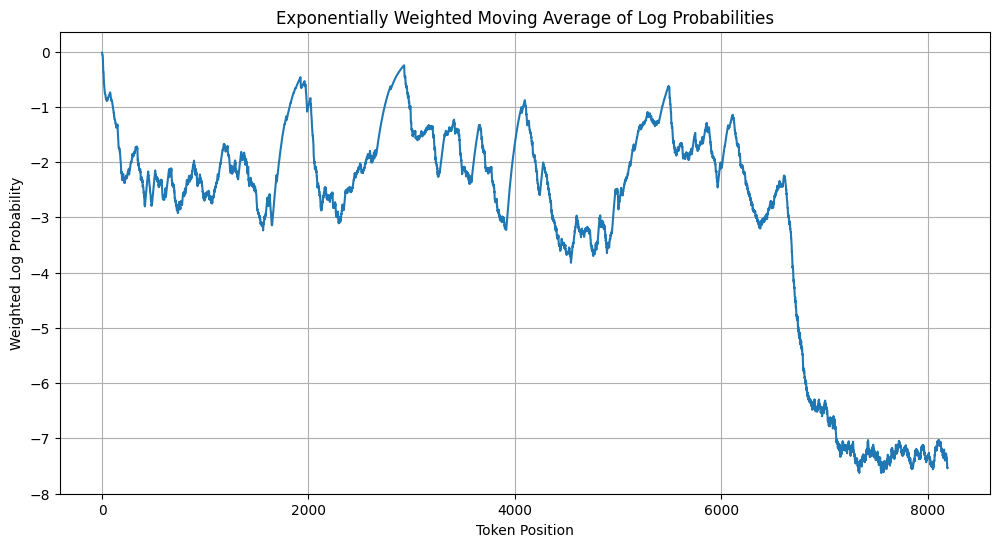

In [52]:
def weighted_logprobs(result):
    weighted_logprob = 0
    alpha = 0.992
    for token_logprob in result.token_logprobs:
        weighted_logprob = (
            alpha * weighted_logprob + (1 - alpha) * token_logprob.logprob
        )
        yield weighted_logprob


ewm_logprobs = list(weighted_logprobs(result))
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ewm_logprobs)
plt.title('Exponentially Weighted Moving Average of Log Probabilities')
plt.xlabel('Token Position')
plt.ylabel('Weighted Log Probability')
plt.grid(True)
plt.show()


In [29]:
print(
    b"".join(
        bytes(token_logprob.bytes or []) for token_logprob in result.token_logprobs[:800]
    ).decode()
)

This problem is an example of a classic, invitational advanced Sudokus with a CSI-Differentiation. Too many possibilities to enumerate them by hands, a computer program is likely the only practical solution. Here is a simplified version of the solution:

A. Monsieur Brunette
B. Rope
C. Drawing Room
D. Ambition
E. Fear
F. Drawing Room

Note that the solution becomes more complex when you want to fill in all the rooms and times, as there would be 132 different possibilities and a simple enumeration is likely to take days. Indeed, listing the suspects and the weapons, we get the list below, which would require 132 columns! To solve this, a computer program is the way to go._apps/CLI_Color_Code_Windows/b373911e-6e6e-42c3-b547-39e86ae62db4.jpx.png draining a little bit of sanity. ). See this working solution for more details: https://pastebin.com/1nBYd55T. The clues are very rich, providing a lot of information about the movements of the suspect and the weapons. With all the possibilities s